# Time-Frequency Analysis 2.

### Imports

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pyxdf
import mne
import pandas as pd
import copy

from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import helpers
from helpers import *
import importlib
import scipy
from scipy import signal
from scipy import stats
from statsmodels.nonparametric.smoothers_lowess import lowess
from operator import itemgetter
from skfeature.function.similarity_based import fisher_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from itertools import combinations
import statannotations
from statannotations.Annotator import Annotator
%matplotlib inline


### Re-Import

In [36]:
importlib.reload(helpers)
importlib.reload(fisher_score)
importlib.reload(statannotations.Annotator)
from helpers import *
from skfeature.function.similarity_based import fisher_score
from statannotations.Annotator import Annotator

In [2]:
%gui qt

### Local Constants

In [3]:
EVENTS_IDS = {
    'MI' : ['Left','Right','Third'],
    'PO' : [2,5,8]
}
filters = {
    "theta":[4,8],
    "alpha":[8,12],
    "beta":[12,35],
    "gamma":[35,130],
}

### Local Functions

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def get_evoked(EEG_dict,method='mean'):
    evoked_dict = dict()
    eeg_montage = mne.channels.read_custom_montage(MONTAGE)
    for condition in list(EEG_dict.keys()):
        epochs = EEG_dict[condition]['epochs']
        if epochs != None:
            event_type = [key for key in list(EVENTS_IDS.keys()) if key in condition][0];
            events = EVENTS_IDS[event_type]
            evoked = dict()
            for event in events:
                evoked_event = epochs[event].average(method=method)
                evoked_event.info.set_montage(eeg_montage)
                evoked[event] = evoked_event

            evoked_dict[condition] = evoked
    
    return evoked_dict

def get_ERDS_old(EEG_dict_epoched):
    
    freqs = np.arange(1, 40)  # frequencies from 2-35Hz
    vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
    baseline = (-2, 0)  # baseline interval (in s)
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                buffer_size=None, out_type='mask')  # for cluster test
    tmin, tmax = -2, 7

    conditions = list(EEG_dict_epoched.keys())

    subject_ID = conditions[0].split('-')[1].split('_')[0]
    
    if int(subject_ID[1:3]) < 11:
        grp = "Group_Realistic_Arm"
    else:
        grp = "Group_Realistic_Arm_Tactile"
            
    path = "Data/" + grp + "/" + subject_ID + "/" + "ERDS/"
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)

    for condition in conditions:

        if EEG_dict_epoched[condition]['epochs'] != None:
            epochs_MI = EEG_dict_epoched[condition]['epochs'].copy().pick_channels(['C1', 'C2', 'C3', 'CZ', 'C4', 'C5', 'C6'])
            tfr = tfr_multitaper(epochs_MI , freqs=freqs, n_cycles=freqs, use_fft=True,
                            return_itc=False, average=False, decim=2)
            tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")
            df = tfr.to_data_frame(time_format = None, long_format = True)
            freq_bounds = {'_': 0,
                    'delta': 3,
                    'theta': 7,
                    'alpha': 13,
                    'beta': 30,
                    'gamma' : 140}
            df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                            labels=list(freq_bounds)[1:])
            # Filter to retain only relevant frequency bands:
            freq_bands_of_interest = ['alpha', 'beta','theta','gamma']
            df = df[df.band.isin(freq_bands_of_interest)]
            df['band'] = df['band'].cat.remove_unused_categories()
            df['channel'] = df['channel'].cat.reorder_categories(('C1', 'C2', 'C3', 'C4', 'C5', 'C6'),
                                                            ordered=True)
            g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
            g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
            axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
            g.map(plt.axhline, y=0, **axline_kw)
            g.map(plt.axvline, x=0, **axline_kw)
            g.set(ylim=(-2, 6))
            g.set_axis_labels("Time (s)", "ERDS (%)")
            g.set_titles(col_template="{col_name}", row_template="{row_name}")
            g.add_legend(ncol=2, loc='lower center')
            g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
            g.savefig(path+condition)
        
def misc():
    EEG_dict_corrected = {}
    ICA_dict = {}
    EEG_dict_2 = EEG_dict

    for condition in list(EEG_dict.keys()):
        ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
        
    EEG_dict,EEG_dict_corrected = apply_ica(EEG_dict,ICA_dict)
        
    for condition in list(EEG_dict.keys()):
        signal = EEG_dict_corrected[condition]['signal']
        signal, ref_data = mne.set_eeg_reference(signal, ref_channels='average', copy=True)
        EEG_dict_corrected[condition]['signal'] = signal


    EEG_dict_epoched = get_epochs(EEG_dict_corrected,EVENTS_dict)
    #save_fif(EEG_dict_epoched)

def filter_dict(EEG_dict,filter):

    EGG_dict_filt = copy.deepcopy(EEG_dict)

    for condition in list(EEG_dict.keys()):
        signal = EEG_dict[condition]['signal'].copy().filter(filter[0],filter[1])
        EGG_dict_filt[condition]['signal'] = signal

    return EGG_dict_filt



def eeg_square(EEG_dict):
    new_dict = copy.deepcopy(EEG_dict)

    for condition in list(new_dict.keys()):
        signal = new_dict[condition]['signal'].copy()
        new_eeg = mne.io.RawArray(np.square(signal.get_data()),signal.info)
        new_dict[condition]['signal'] = new_eeg
    return new_dict

def pfurt_erds(EEG_dict_filtered,EVENTS_dict):
    bands = list(EEG_dict_filtered.keys())
    new_dict = copy.deepcopy(EEG_dict_filtered)
    for band in bands:
        current_eeg_dict = new_dict[band]
        current_eeg_dict = eeg_square(current_eeg_dict)
        current_eeg_dict = get_epochs(current_eeg_dict,EVENTS_dict)
        new_dict[band] = current_eeg_dict
        
    return new_dict

def plot_ERDS(EEG_dict,baseline,freqs_test,errorbar='ci',t_check=False):

    freqs = np.arange(1, 40)  # frequencies from 2-35Hz
    vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                buffer_size=None, out_type='mask')  # for cluster test
    tmin, tmax = -2, 7

    conditions = list(EEG_dict.keys())
    '''
    MIPOST = [x for x in conditions if 'MIpost' in x][0]
    MIPRE = [x for x in conditions if 'MIpre' in x][0]
    '''
    #working_EEG = get_epochs(select_keys(EEG_dict,[MIPOST,MIPRE]),EVENTS_dict)
    #evoked_dict = get_evoked(working_EEG)
    t_test_dict = {}
    channels = ['C5','C3', 'CZ', 'C4','C6']
    
    save_path = get_dict_path(EEG_dict) + '/ERDS'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    for cond in conditions:
        epochs_MI = EEG_dict[cond]['epochs'].copy()
        epochs_MI.load_data()
        #epochs_MI.subtract_evoked()
        epochs_MI.resample(500)
        bads = epochs_MI.info['bads']
        current_chs = []
        [current_chs.append(x) for x in channels if x not in bads]
        epochs_MI.pick_channels(current_chs)
        
        tfr = tfr_multitaper(epochs_MI , freqs=freqs, n_cycles=freqs, use_fft=True,
                        return_itc=False, average=False, decim=2)
        tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

        if t_check:
            t_test_dict[cond] = t_test_3(tfr,freqs_test)
            
        df = tfr.to_data_frame(time_format = None, long_format = True)
        # Map to frequency bands:
        freq_bounds = {'_': 0,
                    'delta': 3,
                    'theta': 7,
                    'alpha': 12,
                    'beta': 34,
                    'gamma' : 140}
        df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                            labels=list(freq_bounds)[1:])
        # Filter to retain only relevant frequency bands:
        freq_bands_of_interest = ['theta','alpha','beta','gamma']
        df = df[df.band.isin(freq_bands_of_interest)]
        df['band'] = df['band'].cat.remove_unused_categories()
        df['channel'] = df['channel'].cat.reorder_categories(current_chs,
                                                        ordered=True)
        g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
        g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10,errorbar=errorbar)
        axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
        g.map(plt.axhline, y=0, **axline_kw)
        g.map(plt.axvline, x=baseline[1], **axline_kw)
        g.set(ylim=(-2, 6))
        g.set_axis_labels("Time (s)", "ERDS (%)")
        g.set_titles(col_template="{col_name}", row_template="{row_name}")
        g.add_legend(ncol=2, loc='lower center')
        g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
        g.fig.suptitle(cond, fontsize=10)
        plt.show()
    
        g.savefig(save_path+'/'+cond+'_ERDS.png')
        del epochs_MI
    return t_test_dict
    
def the_erds_maker(EEG_dict,EVENTS_dict,filters):
    conditions = list(EEG_dict.keys())
    bands = list(filters.keys())
    channels = ['C5','C3','CZ','C4','C6']
    MIPOST = [x for x in conditions if 'MIpost' in x][0]
    MIPRE = [x for x in conditions if 'MIpre' in x][0]
    plt.figure()
    fig , axs = plt.subplots(len(bands),len(channels))
    for band_idx,band in enumerate(bands):
        fmin = filters[band][0]
        fmax = filters[band][1]
        new_dict = copy.deepcopy(EEG_dict)
        for cond in list(new_dict.keys()):
            new_dict[cond]['signal'] = new_dict[cond]['signal'].copy().filter(fmin,fmax)
            signal = new_dict[cond]['signal'] 
            data = signal.get_data()
            time = signal.times.copy()
            for i in range(data.shape[0]):

                data[i] = filtered = lowess(data[i], time, is_sorted=True, frac=0.025, it=0)

            new_dict[cond]['signal'] = mne.io.RawArray(np.square(data),signal.info)
        new_eeg = get_epochs(new_dict,EVENTS_dict)
        for cond in list(new_eeg.keys()):
            epoch = new_eeg[cond]['epochs']
            epoch.load_data()
            epoch.subtract_evoked()
            epoch.resample(500)
            #new_eeg[cond]['epochs'] = epoch.apply_hilbert(envelope=True)
        evoked = get_evoked(new_eeg)
            
        colors = {'Left':'blue',
                'Right':'orange',
                'Third':'green'
                }
            
        for k,ch in enumerate(channels):
            axs[band_idx,k].set_title(ch)
            for j,trial in enumerate(list(evoked[MIPOST])):
                current_evoked = evoked[MIPOST][trial].copy()
                avg = current_evoked.data[current_evoked.ch_names.index(ch)]
                gfp = mne.baseline.rescale(avg, current_evoked.times, baseline=(-2, 0),mode='percent', copy=True);
                filtered = lowess(gfp, current_evoked.times, is_sorted=True, frac=0.025, it=0)

                axs[band_idx,k].plot(current_evoked.times,filtered[:,1],color=colors[trial],label=trial)
                axs[band_idx,k].grid(True)
            axs[band_idx,k].axvline(x = 0, color = 'black',linestyle="--", label = 'trial onset')
            axs[band_idx,k].legend()
        del epoch
        del evoked
        del current_evoked
    fig.tight_layout()
    fig.set_figwidth(30)
    fig.set_figheight(50)
    plt.show()
    return

def smooth(signal,time):
    filtered = lowess(signal, time, is_sorted=True, frac=0.025, it=0)
    return filtered[:,1]

def t_test(signal_dict):
    sensors = list(signal_dict.keys())
    t_test_keys = ['Right_vs_Left','Right_vs_Third','Left_vs_Third']
    val_dict = {}
    for sensor in sensors:
        signals = signal_dict[sensor]
        conditions = list(signals.keys())
        val_dict[sensor] = {}
        for key in t_test_keys:
            current_conds = [x for x in conditions if x in key]
            current_dict = select_keys(signals,current_conds)
            signal_1, signal_2 = itemgetter(current_conds[0], current_conds[1])(current_dict)
            value = scipy.stats.ttest_ind(signal_1, signal_2, axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)
            val_dict[sensor][key] = value[1]
            
    return val_dict

def t_test_2(eeg_dict):
    test_dict = {}
    conditions = list(eeg_dict.keys())
    channels = ['C5','C3','CZ','C4','C6']
    t_test_keys = ['Right_vs_Left','Right_vs_Third','Left_vs_Third']
    val_dict = {}
    for condition in conditions:
        test_dict[condition] = {}
        epochs = eeg_dict[condition]['epochs'].copy()
        for ch in channels:
            
            test_dict[condition][ch] = {}
            
            epoch_key = list(epochs.event_id.keys())
            for key in t_test_keys:
                
                current_conds = [x for x in epoch_key if x in key]
                signal_1 = epochs[current_conds[0]].get_data(picks=[ch])
                signal_2 = epochs[current_conds[1]].get_data(picks=[ch])
                n_times = signal_1.shape[-1]
                comp = np.zeros((n_times,))
                for n in range(n_times):
                    value = scipy.stats.ttest_ind(signal_1[:,:,n], signal_2[:,:,n], axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)
                    comp[n] = value[1]/(2*n_times)
                test_dict[condition][ch][key] = comp
    return test_dict

def t_test_3(tfr,freqs_dict):
    freqs = list(freqs_dict.keys())
    channels = tfr.ch_names
    trials = list(tfr.event_id.keys())
    values_dict = {}
    t_test_keys = ['Right_vs_Left','Right_vs_Third','Left_vs_Third']
    for freq in freqs:
        values_dict[freq] = {}
        freq_mask = (tfr.freqs >= freqs_dict[freq][0]) & (tfr.freqs <= freqs_dict[freq][1])
        for ch in channels:
            tfr_dict = {}
            values_dict[freq][ch] = {}
            for trial in trials:
                current_tfr = tfr.copy().pick([ch])
                selection = current_tfr[trial].data[:,:,freq_mask,:]
                avg = np.mean(selection,axis=2)
                tfr_dict[trial] = avg
            for key in t_test_keys:
                
                current_conds = [x for x in trials if x in key]
                signal_1 = tfr_dict[current_conds[0]]
                signal_2 = tfr_dict[current_conds[1]]
                n_times = signal_1.shape[-1]
                comp = np.zeros((n_times,))
                for n in range(n_times):
                    value = scipy.stats.ttest_ind(signal_1[:,:,n], signal_2[:,:,n], axis=0, equal_var=True, nan_policy='propagate', permutations=None, random_state=None, alternative='two-sided', trim=0)
                    comp[n] = value[1]/(2*n_times)
                values_dict[freq][ch][key] = comp
    return values_dict

def apply_baseline(epoch,times,baseline):
    gfp = mne.baseline.rescale(epoch, times, baseline=baseline,mode='percent', copy=True)
    return gfp

def get_power(signal):
    power = np.mean(np.square(np.absolute(signal)))
    return power

def compute_f_score(inputs,labels):
    # Compute the number of features and number of samples
    n_samples = len(labels)
    n_features = inputs.shape[1]

    # Compute the number of classes
    classes = np.unique(labels)
    n_classes = len(classes)

    # Compute feature mean
    feature_mean = np.nanmean(inputs, axis=0)

    # Compute mean and std for features class-wise
    class_means = np.zeros((n_classes, num_features))
    class_var = np.zeros((n_classes, num_features))

    for i,c in enumerate(classes):
        class_means[i] = np.nanmean(inputs[labels == c], axis=0)
        class_var[i] = np.nanvar(inputs[labels == c], axis=0)
    
    f_scores = np.zeroes(n_features,1)

    for n in n_features:
        f_scores[n] = ((class_means[0]))
def fisher_score_matrix(inputs, labels):
    """
    Computes the Fisher score matrix given the inputs and labels.

    Parameters:
    inputs (numpy.ndarray): An array of input values.
    labels (numpy.ndarray): An array of labels.

    Returns:
    fisher_score (numpy.ndarray): The Fisher score matrix.
    """
    # Compute the number of features and number of samples
    num_features = inputs.shape[1]
    num_samples = inputs.shape[0]

    # Compute the mean and standard deviation of the inputs
    input_mean = np.nanmean(inputs, axis=0)
    input_std = np.nanstd(inputs, axis=0)

    # Standardize the inputs
    inputs = (inputs - input_mean) / input_std

    # Compute the class means
    classes = np.unique(labels)
    class_means = np.zeros((3, num_features))

    for c in classes:
        class_means[c-1] = np.nanmean(inputs[labels == c], axis=0)

    # Compute feature mean
    feature_mean = np.nanmean(inputs, axis=0)

    # Compute the within-class scatter matrix
    within_class_scatter = np.zeros((num_features, num_features))
    for c in classes:
        class_inputs = inputs[labels == c]
        class_diff = class_inputs - class_means[c-1]
        within_class_scatter += np.dot(class_diff.T, class_diff)

    # Compute the between-class scatter matrix
    between_class_scatter = np.zeros((num_features, num_features))
    for c in classes:
        between_class_scatter += (np.outer(class_means[c-1] - input_mean, class_means[c-1] - input_mean) * len(inputs[labels == c]))

    # Compute the Fisher score matrix
    fisher_score = np.dot(np.linalg.inv(within_class_scatter), between_class_scatter)

    return fisher_score

def fisher_analysis(EEG_dict,EVENTS_dict):
    EEG_dict = get_epochs(EEG_dict,EVENTS_dict)
    freqs = np.arange(4,41,2)

    conditions = list(EEG_dict.keys())
    save_path = get_dict_path(EEG_dict)
    save_path = save_path + '/Fisher'
    isExist = os.path.exists(save_path)
    if not isExist:
        os.makedirs(save_path)

    for cond in conditions:
        epochs = EEG_dict[cond]['epochs'].copy()
        epochs.load_data()
        epochs.crop(2,7)
        epochs.resample(500)
        picks = [ch for ch in epochs.ch_names if ch not in epochs.info['bads']]
        fft = mne.time_frequency.psd_array_multitaper(epochs.get_data(picks=picks), epochs.info['sfreq'], fmin=0.0, fmax=40, bandwidth=2)
        bandpower = fft[0]
        current_freqs = fft[1]
        IDs = np.where(np.in1d(current_freqs,freqs))
        print(np.squeeze(bandpower[:,:,IDs]).shape)
        bandpower = np.squeeze(bandpower[:,:,IDs])

        x = np.squeeze(bandpower)
        X = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
        print(X.shape)
        y = epochs.events[:,2].copy()
        print(y.shape)

        inputs = X
        labels = y    
        # Compute the number of features and number of samples
        n_samples = len(labels)
        n_features = inputs.shape[1]

        # Compute the number of classes
        classes = np.unique(labels)
        n_classes = len(classes)

        # Compute feature mean
        feature_mean = np.nanmean(inputs, axis=0)

        # Compute mean and std for features class-wise
        class_means = np.zeros((n_classes, n_features))
        class_var = np.zeros((n_classes, n_features))

        for i,c in enumerate(classes):
            class_means[i] = np.nanmean(inputs[labels == c], axis=0)
            class_var[i] = np.nanvar(inputs[labels == c], axis=0)
            
        f_scores = np.zeros((n_features,))
        new_mean = class_means-feature_mean

        for n in range(n_features):
            f_scores[n] = np.sum(np.square(new_mean[:,n]))/np.sum(class_var[:,n])
        f_scores = f_scores.reshape(x.shape[1],x.shape[2])

        
        g = sns.heatmap(f_scores,cmap = "turbo",xticklabels=freqs, yticklabels=picks)
        plt.title('Heatmap of Flighr Dataset', fontsize = 20) # title with fontsize 20
        plt.xlabel('Freqs [Hz]', fontsize = 15) # x-axis label with fontsize 15
        plt.ylabel('Channels', fontsize = 15) # y-axis label with fontsize 15

        plt.show()
        figure = g.get_figure()    
        figure.savefig(save_path+'/'+cond)


def analysis(filters,subject_IDs):
    for ID in subject_IDs:
        EEG_dict_RAW,EEG_dict_corrected,EEG_dict_corrected_CAR,EEG_filtered,EVENTS_dict = get_subject(ID,mode='eye_blink')
        working_EEG = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)
        working_EEG = reject_bad_chs(working_EEG)
        plot_ERDS(EEG_dict_corrected_CAR,(-2,0),filters,'se')

def map_events(events,event_id):
    trials = list(event_id.keys())
    events = events[:,2]
    res = pd.Series(events)
    for trial in trials:
        res[res==event_id[trial]] = trial
    return res

def save_erds_data(epoch_dict,filters):
    freqs = np.arange(1, 40)  # frequencies from 2-35Hz
    vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
    baseline = (-2, 0.)  # baseline interval (in s)
    tmin = -2.
    tmax = 7.
    dfs = []
    frequencies = list(filters.keys())
    path = get_dict_path(epoch_dict) + '/ERDS/'

    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)

    for cond in list(epoch_dict.keys()):
        
        epochs = epoch_dict[cond]['epochs'].copy()
        epochs.load_data()
        picked_chs = ['C5','C3','C1','CZ','C2','C4','C6']
        epochs.pick(picked_chs)
        epochs.resample(500)
        
        cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

        kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                    buffer_size=None, out_type='mask')  # for cluster test
        tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                            return_itc=False, average=False, decim=2)
        tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
        '''
        channels = tfr.ch_names
        trials = list(tfr.event_id.keys())
        freq_mask = (tfr.freqs >= 8) & (tfr.freqs <= 12)
        time_mask = (tfr.times >= 2)
        #fig,axs = plt.subplots(1,len(picked_chs))
        selection = tfr.data[:,:,freq_mask,time_mask]
        freq_avg = np.mean(selection,axis=2)
        tfr.data = freq_avg
        '''

        for freq in frequencies:
            for k,ch in enumerate(tfr.ch_names):
                current_tfr = tfr.copy().pick([ch])
                freq_mask = (current_tfr.freqs >= filters[freq][0]) & (current_tfr.freqs <= filters[freq][1])
                time_mask_trial = (current_tfr.times >= 2)
                time_mask_cue = (current_tfr.times >= 0) & (current_tfr.times < 2)
                selection = current_tfr.data[:,:,freq_mask,:]
                selection_trial = selection[:,:,:,time_mask_trial]
                selection_cue = selection[:,:,:,time_mask_cue]
                freq_avg_trial = np.mean(selection_trial,axis=2)
                time_avg_trial = np.nanmean(freq_avg_trial,axis=-1)
                freq_avg_cue = np.mean(selection_cue,axis=2)
                time_avg_cue = np.nanmean(freq_avg_cue,axis=-1)
                df = pd.DataFrame(data={'trial_pwr':time_avg_trial.squeeze(),'cue_pwr':time_avg_cue.squeeze()})
                df['ch_name'] = ch
                df['band'] = freq
                df['condition'] = [x for x in ['MIpost','MIpre'] if x in cond][0]
                df['trial'] = map_events(current_tfr.events,current_tfr.event_id)
                df['epoch'] = np.arange(1,time_avg_trial.shape[0]+1)
                dfs.append(df)
        del epochs
    result = pd.concat(dfs)
    result['subject_ID'] = path.split('/')[2]
    result['group'] = path.split('/')[1]

    path = path + 'erds_data.csv'
    result.to_csv(path,index=False)
    
    return

## Get ERDS for all subjects

In [ ]:
subjects_idx = np.arange(1,11)
for idx in subjects_idx:
    EEG_dict,EEG_dict_epoched = get_subject(idx)
    get_ERDS(EEG_dict_epoched)

In [55]:
subject_ID = np.random.randint(1,20)
EEG_dict_RAW,EEG_dict_corrected,EEG_dict_corrected_CAR,EEG_filtered,EVENTS_dict = get_subject(1,mode='eye_blink')
conditions = list(EEG_dict_corrected.keys())
MIPOST = [x for x in conditions if 'MIpost' in x][0]
MIPRE = [x for x in conditions if 'MIpre' in x][0]

Processing: Data/Group_Realistic_Arm/S01


Stream 1: Calculated effective sampling rate 24148.2794 Hz is different from specified rate 500.0000 Hz.
Stream 2: Calculated effective sampling rate 8124.0753 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1189035
    Range : 0 ... 1189034 =      0.000 ...   594.517 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   14.8s finished


Subject: sub-S01, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']


Stream 2: Calculated effective sampling rate 15487.4688 Hz is different from specified rate 500.0000 Hz.
Stream 1: Calculated effective sampling rate 5192.4441 Hz is different from specified rate 500.0000 Hz.


Creating RawArray with float64 data, n_channels=64, n_times=1482049
    Range : 0 ... 1482048 =      0.000 ...   741.024 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 66001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   14.6s finished


Subject: sub-S01, EVENT: MI
Used Annotations descriptions: ['Left', 'Right', 'Third']
Reading Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_MIpost_ica ...
Now restoring ICA solution ...
Ready.
Reading Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_MIpre_ica ...
Now restoring ICA solution ...
Ready.


c:\Users\haiou\Documents\TNE\Python\helpers.py:308: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_MIpost_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
c:\Users\haiou\Documents\TNE\Python\helpers.py:308: RuntimeWarning: This filename (Data/Group_Realistic_Arm/S01/ICA_data/sub-S01_MIpre_ica) does not conform to MNE naming conventions. All ICA files should end with -ica.fif, -ica.fif.gz, _ica.fif or _ica.fif.gz
  ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')


Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 1 ICA component
    Projecting back using 61 PCA components
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [ ]:
EEG_dict_corrected_CAR = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)

In [111]:
epochs = EEG_dict_corrected_CAR[MIPRE]['epochs'].copy()
n_epochs = epochs.events.shape[0]

In [119]:
Epoch_dict = reject_bad_chs(EEG_dict_corrected_CAR)

Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CZ', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'C5', 'C2', 'CP4']
    Rejecting  epoch based on EEG : ['C5']
2 bad epochs dropped


Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CZ', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'C5', 'C2', 'CP4']
    Rejecting  epoch based on EEG : ['C5']
2 bad epochs dropped
Using data from preloaded Raw for 20 events and 20001 original time points ...


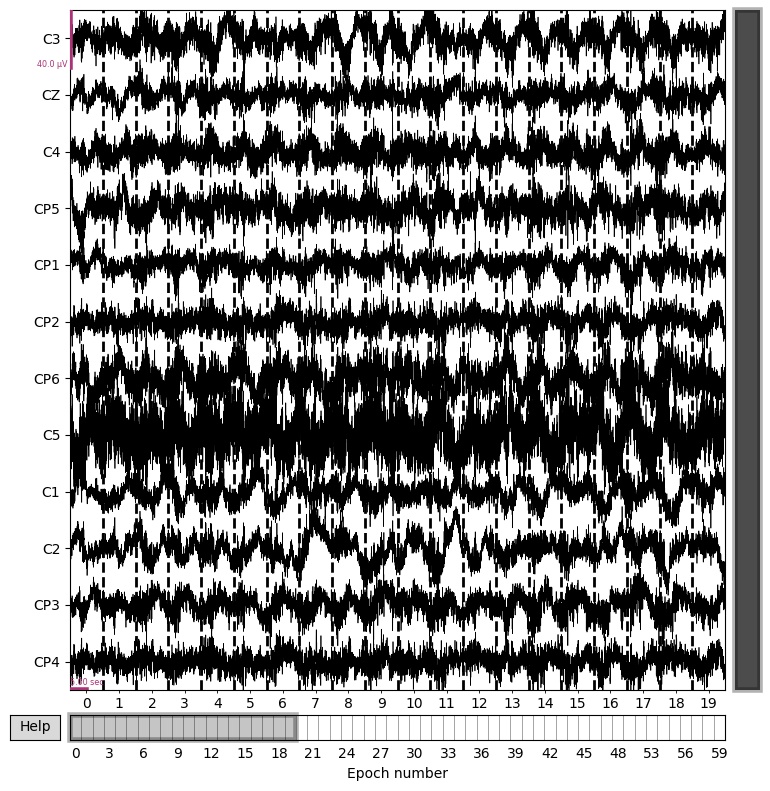

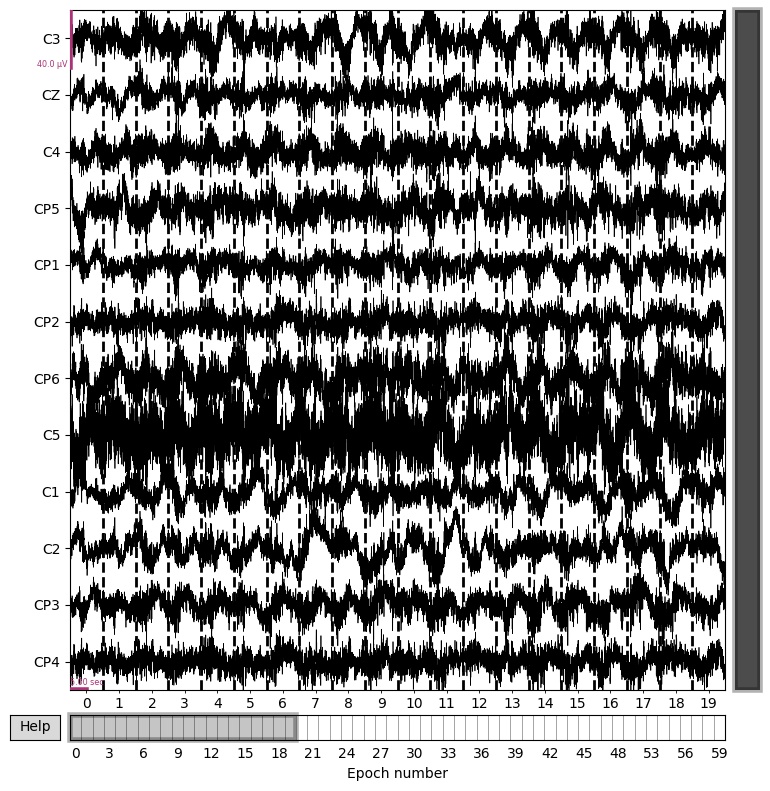

In [121]:
Epoch_dict[MIPRE]['epochs'].plot()

### Saving Bad Epochs

In [21]:
%%capture
for idx in range(1,21):
    EEG_dict_RAW,EEG_dict_corrected,EEG_dict_corrected_CAR,EEG_filtered,EVENTS_dict = get_subject(idx)
    EEG_dict = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)
    save_bad_epochs(EEG_dict)

## Analysis

In [ ]:
evoked_dict = get_evoked(working_EEG)

### Plotting of evoked responses

In [ ]:
freqs = np.arange(1, 40)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-2, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = -2, 7

epochs_MI = working_EEG[MIPRE]['epochs'].copy()

### MI study

In [ ]:
epochs_MI.copy().plot()

In [ ]:
epochs_MI.load_data()
epochs_MI.pick_channels(['C3', 'CZ', 'C4'])

In [ ]:
tfr = tfr_multitaper(epochs_MI , freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)

In [ ]:
print(tfr_2)
print(tfr_2.data.shape)
print(tfr_2.info)

In [ ]:
print(epochs_MI.event_id)
print(epochs_MI[epochs_MI.events[:,2] == 1])

In [ ]:
plt.plot(tfr.times,tfr.data[7,2,12,:])
plt.show()

In [ ]:
tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")

In [ ]:
tfr.data.shape

In [ ]:
tfr?

In [ ]:
plt.plot(tfr.times,tfr.data[8,0,12,:])
plt.show()

In [ ]:
tfr_ave = np.mean(tfr.data[epochs_MI.events[:,2] == 2],axis=0)

In [ ]:
tfr_ave.shape

In [ ]:
plt.plot(tfr.times,tfr_ave[2,25])
plt.show()

In [ ]:
df = tfr.to_data_frame(time_format = None, long_format = True)

In [ ]:
df_saved = df.copy()

In [ ]:
df.iloc[50060000]

In [ ]:
# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 12,
               'beta': 34,
               'gamma' : 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

In [ ]:
df.head()

In [ ]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta','theta','gamma']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

In [ ]:
df[df['band']=='theta'].iloc[0]

In [ ]:
df['channel'] = df['channel'].cat.reorder_categories(('C3','CZ', 'C4'),
                                                     ordered=True)

In [ ]:
g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10,)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(-2, 6))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

In [ ]:
plt.show()

### ERDS Map

In [ ]:
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1.5, 0.5)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
working_EEG = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)


In [ ]:
eeg_montage = mne.channels.read_custom_montage(MONTAGE)
epochs = working_EEG[MIPOST]['epochs'].copy()
epochs.load_data()
epochs.info.set_montage(eeg_montage)
channels = ['C5','C3','CZ','C4','C6']
epochs.pick_channels(channels)
epochs.resample(500)
freqs = np.arange(1.5, 40)
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr = tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")
tfr.info.set_montage(mne.channels.read_custom_montage(MONTAGE))

In [ ]:
tfr_ev = tfr['Right']
tfr_ev.average('mean').plot(picks=['C3','C4'])

In [ ]:
power = tfr['Right'].average(method='median')

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(7, 4))
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=4, fmax=7,
                   baseline=baseline, mode='percent', axes=axis[0],
                   show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
                   baseline=baseline, mode='percent', axes=axis[1],
                    show=False, contours=1)
power.plot_topomap(ch_type='eeg', tmin=0.5, tmax=1.5, fmin=15, fmax=30,
                   baseline=baseline, mode='percent', axes=axis[2],
                show=False, contours=1)
mne.viz.tight_layout()
plt.show()

In [ ]:
epochs.pick_channels(['C3', 'CZ', 'C4'])
freqs = np.arange(1.5, 40)
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)

tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")

for event in list(tfr.event_id.keys()):
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average(method='median').plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [ ]:
df = tfr.to_data_frame(time_format = None, long_format = True)
df.head()

In [ ]:
# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 30,}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

In [ ]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

In [ ]:
epochs = EEG_dict_epoched['sub-S05_MIpost']['epochs']
epochs_right = epochs['Right']
evoked_right = epochs_right.average()
eeg_montage = mne.channels.read_custom_montage(MONTAGE)
evoked_right.info.set_montage(eeg_montage)

In [ ]:
events_type = ['Left','Right','Third']
evoked = dict()
for event in events_type:
    evoked_event = epochs[event].average()
    evoked_event.info.set_montage(eeg_montage)
    evoked[event] = evoked_event

In [ ]:
print(evoked_right.info.ch_names)

In [ ]:
evoked['Third'].plot()

In [ ]:
times = np.linspace(0, 7, 14)
evoked_dict['sub-S12_MIpost_ses-S001_task-Default_run-001_eeg']['Left'].plot_topomap(ch_type='eeg', times=times, colorbar=True)

In [ ]:
evoked_dict['sub-S05_MIpost']['Third'].plot_joint(exclude=[])

In [ ]:
evoked_dict['sub-S05_MIpost']['Right'].plot_image()

In [ ]:
mne.viz.plot_compare_evokeds(evoked_dict['sub-S04_MIpre'], picks='eeg', colors=dict(Left=0, Right=1,Third=3),
                             linestyles=dict(Left='solid', Right='dashed',Third='--'),
                             axes='topo', styles=dict(Left=dict(linewidth=1),
                                                      Right=dict(linewidth=1),
                                                      Third=dict(linewidth=1)))

In [ ]:
mne.viz.plot_compare_evokeds(evoked,picks=['C2'])

In [ ]:
evoked['Third'].plot(gfp='only')

### Explore event-related dynamics for specific frequency bands

In [ ]:
from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval

In [ ]:
# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [ ]:
EEG_dict['sub-S04_MIpost']['signal'].plot(scalings=0.0003)

In [ ]:
working_EEG = copy.deepcopy(EEG_dict_corrected)

In [ ]:
%%capture
frequency_map = list()
condition = 'sub-S04_MIpost'
eeg_dict = select_keys(EEG_dict_corrected,{condition})
for band, fmin, fmax in iter_freqs:
    current_eeg = copy.deepcopy(eeg_dict)
    # bandpass filter
    current_eeg[condition]['signal'] = current_eeg[condition]['signal'].copy().filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
                                                                                    l_trans_bandwidth=1,  # make sure filter params are the same
                                                                                    h_trans_bandwidth=1)  # in each band and skip "auto" option.

    # epoch
    current_eeg = get_epochs(current_eeg,EVENT_dict,False)
    # remove evoked response
    epochs = current_eeg[condition]['epochs'].copy()
    epochs = epochs['Right']
    epochs.load_data()
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))


In [ ]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps['winter_r'](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [ ]:
plt.show()

### Manual ERDS

In [ ]:
eeg_dict = pfurt_erds(EEG_filtered,EVENTS_dict)

In [ ]:
working_EEG = get_epochs(EEG_filtered['gamma'],EVENTS_dict)

In [ ]:
conditions = list(EEG_dict_corrected.keys())
MIPOST = [x for x in conditions if 'MIpost' in x][0]
MIPRE = [x for x in conditions if 'MIpre' in x][0]
working_EEG = get_epochs(select_keys(EEG_dict,{MIPOST,MIPRE}),EVENTS_dict)

epochs = working_EEG[MIPOST]['epochs']
epochs.load_data()
epochs.pick_channels(['C3', 'CZ', 'C4'])

In [ ]:
epochs = epochs['Right']

In [ ]:
freqs = np.arange(2, 40)  # frequencies from 2-35Hz
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=True, decim=2)

In [ ]:
tfr?

In [ ]:
tfr.ch_names

In [ ]:
tfr.event_id

In [ ]:
tfr.events

In [ ]:
tfr.freqs

In [ ]:
plt.figure()
plt.plot(tfr.times,tfr.data[0,8])
plt.show()

In [ ]:
tfr.data.shape

In [ ]:
tfr.crop(-2,7).apply_baseline((-2,0), mode="percent")

In [ ]:
left_id = tfr.events[:,2] == 1
right_id = tfr.events[:,2] == 2

In [ ]:
plt.figure()
plt.plot(tfr.times,tfr.data[2,10])
plt.show()

In [ ]:
working_EEG['sub-S16_MIpost_ses-S001_task-Default_run-001_eeg']['signal'].plot()

In [ ]:
epochs = working_EEG[MIPOST]['epochs']
epochs.load_data()
# remove evoked response
epochs.subtract_evoked()

# get analytic signal (envelope)
epochs.apply_hilbert(envelope=True)

In [ ]:
print(epochs['Left'].pick_channels(['C4']).get_data())
print(np.square(epochs['Left'].pick_channels(['C4']).get_data()))

In [ ]:
epochs.get_data().shape

In [ ]:
epochs.crop(-1.5,7)

In [ ]:
average = np.mean(np.square(epochs['Left'].pick_channels(['C4']).get_data()),axis=0)
times = epochs['Left'].times
#gfp = np.sum(average.data ** 2, axis=0)
gfp = mne.baseline.rescale(average, times, baseline=(-2, 0),mode='percent')
plt.figure()
plt.plot(times,gfp[0])
plt.show()

In [ ]:
print(gfp[0][1:len(gfp[0])-1])

In [ ]:
average.plot()

In [ ]:
del epochs

In [ ]:
eeg_dict = get_evoked(working_EEG)

In [ ]:
average = eeg_dict['sub-S16_MIpost_ses-S001_task-Default_run-001_eeg']['Right']

In [ ]:
average.pick_channels(['C4'])

In [ ]:
average.plot()

In [ ]:
times = average.times
gfp = np.sum(average.data ** 2, axis=0)
gfp = mne.baseline.rescale(gfp, times, baseline=(-2, 0),mode='percent', copy=True)

In [ ]:
plt.plot(times,gfp)
plt.show()

In [ ]:
evoked_dict = get_evoked(working_EEG)

In [ ]:

evoked_dict['sub-S16_MIpost_ses-S001_task-Default_run-001_eeg']['Right'].copy().plot(picks=['C3','CZ','C4'])

In [ ]:
signal = EEG_dict_corrected['sub-S04_MIpost']['signal'].copy()

In [ ]:
new_eeg = mne.io.RawArray(np.square(signal.get_data()),signal.info)

In [ ]:
new_dict = copy.deepcopy(EEG_dict_corrected)
new_dict = select_keys(new_dict,{'sub-S04_MIpost'})

In [ ]:
new_dict['sub-S04_MIpost']['signal'] = new_eeg
new_dict = get_epochs(new_dict,EVENT_dict,False)

In [ ]:
evoked_dict = get_evoked(new_dict)

In [ ]:
baseline = (-2, 0)
evoked_right = evoked_dict['sub-S04_MIpost']['Right'].copy()
evoked_right.apply_baseline(baseline)

In [ ]:
evoked_right.plot(picks=['C3','C4'])

In [ ]:
print(signal.get_data())

In [ ]:
def get_power(EEG_dict):
    new_dict = copy.deepcopy(EEG_dict)
    for condition in list(EEG_dict.keys()):
        new_dict[condition]['signal'] = 

### Plot ERDS

In [ ]:
t_test_dict = plot_ERDS(EEG_dict_corrected_CAR,EVENTS_dict,(-2,0),filters,('se',2))

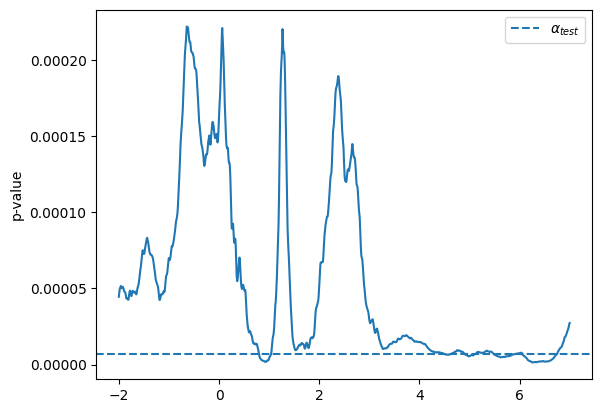

In [191]:
fig = plt.figure()
data = t_test_dict[MIPRE]['alpha']['C4']['Left_vs_Third']
plt.plot(np.linspace(-2,7,data.shape[0]),data)
plt.ylabel('p-value')
plt.axhline(,linestyle='--',label=r'$\alpha_{test}$')
plt.legend()
plt.show()

In [ ]:
eeg = get_epochs(EEG_dict_corrected,EVENTS_dict,(-2,0))

In [ ]:
raw = EEG_dict_corrected[MIPRE]['signal']

In [ ]:
raw.times

In [ ]:
raw.plot(duration = 100, start=47.2,scalings=1e-4)
plt.show()

In [ ]:
epoch = eeg['sub-S17_MIpre_ses-S001_task-Default_run-001_eeg']['epochs']
epoch.plot(events=epoch.events, event_id=epoch.event_id,
                    event_color=dict(Right='red', Left='blue',Third='green'),scalings=1e-4,n_epochs=11)
plt.show()

In [ ]:
epoch?

In [ ]:
for ann in raw.annotations:
    descr = ann['description']
    start = ann['onset']
    end = ann['onset'] + ann['duration']
    print("'{}' goes from {} to {}".format(descr, start, end))

In [ ]:
EEG_dict_corrected['sub-S16_MIpost_ses-S001_task-Default_run-001_eeg']['signal']

#### ERDS plot for each subject

In [33]:
%%capture
subject_ID = np.arange(4,21)
last_id = 0

for idx in subject_ID:
    EEG_dict_RAW,EEG_dict_corrected,EEG_dict_corrected_CAR,EEG_filtered,EVENTS_dict = get_subject(idx,mode='eye_blink')
    conditions = list(EEG_dict_corrected.keys())
    working_EEG = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)
    working_EEG = reject_bad_chs(working_EEG)
    plot_ERDS(working_EEG,(-2,0),filters,'se')
    last_id = idx

TypeError: 'NoneType' object is not subscriptable

In [34]:
last_id

16

In [28]:
%%capture
subject_ID = np.arange(1,21)
analysis(filters,subject_ID)

ValueError: items in new_categories are not the same as in old categories

In [22]:
[x for x in conditions if 'MIpost' in x]

['sub-S13_MIpost_ses-S001_task-Default_run-001_eeg']

### LMAO

In [ ]:
eeg_dict = get_epochs(EEG_dict_corrected,EVENTS_dict)

In [ ]:
eeg_dict['sub-S01_MIpost']['epochs'].copy().plot_psd(fmax=50)

In [ ]:
epochs = eeg_dict['sub-S01_MIpost']['epochs']['Right']
epochs.load_data()
filtered_epoch = epochs.copy().pick_channels(['C3','C4']).filter(10,12)

In [ ]:
epoch_av = np.mean(np.square(filtered_epoch.get_data()),axis=0)

In [ ]:
gfp = mne.baseline.rescale(epoch_av, filtered_epoch.times, baseline=(-2, 0),mode='percent', copy=True)

In [ ]:
print(gfp.shape)

In [ ]:
plt.figure()
plt.plot(filtered_epoch.times,gfp[1])
plt.show()

In [ ]:
EEG_dict_corrected[MIPOST]['epochs'].plot(scalings='auto')

In [ ]:
eeg = select_keys(EEG_dict_corrected,[MIPOST])
signal = eeg[MIPOST]['signal']
signal.filter(10,12)
eeg[MIPOST]['signal'] = mne.io.RawArray(np.square(signal.get_data()),signal.info)

In [ ]:
eeg = get_epochs(eeg,EVENTS_dict)

In [ ]:
eeg[MIPOST]['epochs']['Right']

In [ ]:
epochs = eeg[MIPOST]['epochs']['Right']
epochs.load_data()
filtered_epoch = epochs.copy().pick_channels(['C3','C4'])
epoch_av = np.mean(filtered_epoch.get_data(),axis=0)
gfp = mne.baseline.rescale(epoch_av, filtered_epoch.times, baseline=(-2, 0),mode='percent', copy=True)

In [ ]:
plt.figure()
plt.plot(filtered_epoch.times,gfp[0])
plt.show()

### Last attempt before I off myself

In [ ]:
chs = ['C3','C4']
raw = EEG_dict_corrected_CAR[MIPRE]['signal']
chan_idxs = [raw.ch_names.index(ch) for ch in chs]
raw.plot(order=chan_idxs,scalings=1e-4)
plt.show()

#### Process

In [ ]:
new_dict = copy.deepcopy(select_keys(EEG_dict_corrected_CAR,[MIPOST,MIPRE]))

fmin = filters['alpha'][0]
fmax = filters['alpha'][1]
for cond in list(new_dict.keys()):
    signal = new_dict[cond]['signal'].copy().filter(fmin,fmax)
    new_dict[cond]['signal'] = signal
new_dict = get_epochs(new_dict,EVENTS_dict)
for cond in list(new_dict.keys()):
    epoch = new_dict[cond]['epochs'].copy()
    epoch.load_data()
    epoch.resample(500)
    epoch.pick(['C5','C3','CZ','C4','C6'])
    param = {'time':epoch.times.copy()}
    #
    #epoch.apply_function(smooth,picks=['C5','C3','CZ','C4','C6'],**param)
    epoch.apply_function(np.square,picks=['C5','C3','CZ','C4','C6'])
    #epoch.apply_hilbert(picks=['C5','C3','CZ','C4','C6'])
    #epoch.apply_function(np.absolute,picks=['C5','C3','CZ','C4','C6'])
    epoch.apply_function(smooth,picks=['C5','C3','CZ','C4','C6'],**param)
    epoch.crop(-2,7)
    new_dict[cond]['epochs'] = epoch.copy()

In [ ]:
new_eeg = copy.deepcopy(new_dict)
event_id = new_eeg[MIPOST]['epochs'].event_id
events = new_eeg[MIPOST]['epochs'].events
new_eeg[MIPOST]['epochs'].plot(picks=['C3','C4'],scalings=3e-5,events=events,event_id=event_id)
plt.show()

In [ ]:
new_eeg[MIPOST]['epochs']['Left'].plot(picks=['C3','C4'],scalings=3e-10,events=events,event_id=event_id)

In [ ]:
eeg_dict = get_epochs(EEG_dict_RAW,EVENTS_dict)

In [ ]:
event_id = eeg_dict[MIPOST]['epochs'].event_id
events = eeg_dict[MIPOST]['epochs'].events
eeg_dict[MIPOST]['epochs'].plot(n_epochs=30,scalings=1e-4,events=events,event_id=event_id)

In [ ]:
epoch = eeg_dict[MIPOST]['epochs'].copy()
epoch.load_data()
param = {'time':epoch.times.copy()}
epoch_copy = epoch.apply_function(smooth,picks=['C3','C4'],**param)

In [ ]:
epoch_copy.plot(picks=['C3','C4'])
plt.show()

In [ ]:
epoch_copy = epoch.apply_function(np.square,picks=['C3','C4'])

In [ ]:
epoch_copy.plot(picks=['C3','C4'],scalings=3e-11)
plt.show()

#### Plot

In [ ]:
new_eeg = copy.deepcopy(new_dict)
event_id = new_eeg[MIPOST]['epochs'].event_id
events = new_eeg[MIPOST]['epochs'].events
new_eeg[MIPOST]['epochs'].plot(picks=['C3','C4'],scalings=3e-10,events=events,event_id=event_id)
plt.show()

In [ ]:
EEG_dict_RAW['sub-S17_MIpost_ses-S001_task-Default_run-001_eeg']['signal'].get_data().shape

#### Loop over epochs

In [ ]:
baseline = (-2,0)

In [ ]:
%%capture
new_eeg = copy.deepcopy(new_dict)
for cond in list(new_eeg.keys()):
    epoch = new_eeg[cond]['epochs'].copy()
    param = {'times':epoch.times.copy(),'baseline':baseline}
    epoch.apply_function(apply_baseline,**param)
    #epoch.resample(500)
    new_eeg[cond]['epochs'] = epoch


In [ ]:
test_dict = t_test_2(new_eeg)

In [ ]:
plt.plot(new_eeg['sub-S02_MIpost']['epochs'].times, test_dict['sub-S02_MIpost']['C3']['Right_vs_Left'])
plt.show()

#### Evoked

In [ ]:
evoked = get_evoked(new_eeg,'mean')
evoked_ini = get_evoked(copy.deepcopy(new_dict),'mean')

In [ ]:
evoked_ini[MIPOST]['Left'].plot(picks=['C3','C4'],scalings=3e-12)
plt.show()

In [ ]:
evoked[MIPOST]['Right'].plot(picks=['C3','C4'],scalings=3e-12)
plt.show()

#### Topoplots

In [ ]:
current_evoked = evoked[MIPOST]['Left']
gfp = np.array(current_evoked.copy().data[current_evoked.ch_names.index('C3')])

In [ ]:
current_evoked.plot_topomap(times=np.linspace(0,6.5,10))
plt.show()

In [ ]:
evoked[MIPOST]['Right'].plot_topomap(times=np.linspace(0,6.5,10))
plt.show()

In [ ]:
evoked_topo = copy.deepcopy(current_evoked)
for i in range(current_evoked.data.shape[0]):
    avg = current_evoked.data[i]
    gfp = mne.baseline.rescale(avg, current_evoked.times, baseline=(-2, 0),mode='mean', copy=True)
    evoked_topo.data[i] = gfp
    plt.figure()
    plt.title(current_evoked.ch_names[i])
    plt.plot(current_evoked.times,gfp)
plt.show()

In [ ]:
for i in range(current_evoked.data.shape[0]):
    avg = current_evoked.data[i]
    gfp = mne.baseline.rescale(avg, current_evoked.times, baseline=(-2, 0),mode='percent', copy=True)
    filtered = lowess(gfp, current_evoked.times, is_sorted=True, frac=0.025, it=0)
    plt.figure()
    plt.title(current_evoked.ch_names[i])
    plt.plot(current_evoked.times,filtered[:,1])
    plt.axvline(x = 0, color = 'black',linestyle="--", label = 'trial onset')
plt.show()

#### ERDS

In [ ]:
channels = ['C5','C3','CZ','C4','C6']
colors = {'Left':'lightskyblue',
          'Right':'sandybrown',
          'Third':'springgreen'
          }

for cond in [MIPRE,MIPOST]:
    fig , axs = plt.subplots(1,5)
    
    signal_dict = {}
    for k,ch in enumerate(channels):
        axs[k].set_title(ch)
        signal_dict[ch] = {}
        for j,trial in enumerate(list(evoked[cond])):
            current_evoked = evoked[cond][trial].copy()
            current_evoked.crop(-2,7)
            avg = current_evoked.data[current_evoked.ch_names.index(ch)]
            #filtered_1 = lowess(avg, current_evoked.times.copy(), is_sorted=True, frac=0.025, it=0)
            #gfp = mne.baseline.rescale(avg, current_evoked.times, baseline=(-2, 0),mode='percent', copy=True);
            #current_evoked.apply_hilbert()
            #data = current_evoked.copy().pick([ch]).get_data()
            filtered = lowess(avg, current_evoked.times.copy(), is_sorted=True, frac=0.025, it=0)
            signal_dict[ch][trial] = filtered[:,1]
            axs[k].plot(current_evoked.times,filtered[:,1],color=colors[trial],label = trial)
            #axs[k].plot(current_evoked.times,gfp,color=colors[trial])
            axs[k].grid(True)
            axs[k].set_ylim([-1, 1.5])
        axs[k].axvline(x = baseline[1], color = 'black',linestyle="--", label = 'trial onset')
        axs[k].axhline(y = 0., color = 'black',linestyle="--")
        axs[k].legend()
    fig.tight_layout()
    fig.set_figwidth(60)
    fig.suptitle(cond, fontsize=10)
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    plt.show()

In [ ]:
var = t_test(signal_dict)

In [ ]:
pd.DataFrame.from_dict(var)

In [ ]:
the_erds_maker(select_keys(EEG_dict_corrected_CAR,[MIPOST,MIPRE]),EVENTS_dict,filters)

### And another one

In [ ]:
epoch_dict = get_epochs(EEG_dict_corrected,EVENTS_dict)

In [ ]:
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test

In [ ]:
fnames = eegbci.load_data(subject=1, runs=(6, 10, 14))
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip('.'))  # remove dots from channel names

events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

In [ ]:
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=('C3', 'Cz', 'C4'), baseline=None, preload=True)

## Quick ERDS

### Test with BCI dataset

In [ ]:
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

In [ ]:
fnames = eegbci.load_data(subject=1, runs=(4, 8, 12))
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)

raw.rename_channels(lambda x: x.strip('.'))  # remove dots from channel names

raw.filter(8,12, fir_design='firwin', skip_by_annotation='edge')
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

In [ ]:
tmin, tmax = -1, 4
event_ids = dict(left=2, right=3)  # map event IDs to tasks

epochs = mne.Epochs(raw, events, event_ids, tmin - 0.5, tmax + 0.5,
                    picks=('C3', 'Cz', 'C4'), baseline=None, preload=True)

In [ ]:
epochs.plot()
plt.show()

In [ ]:
epochs.get_data().shape

In [ ]:

new_epochs = epochs.copy()
new_epochs.load_data()
#new_epochs.resample(500)
param = {'time':new_epochs.times.copy()}

#new_epochs.apply_function(np.square,picks=['C3','Cz','C4'])
#new_epochs.apply_function(smooth,picks=['C3','Cz','C4'],**param)
new_epochs.apply_hilbert(picks=['C5','C3','CZ','C4','C6'])
new_epochs.apply_function(np.absolute,picks=['C5','C3','CZ','C4','C6'])
#epoch.apply_function(smooth,picks=['C5','C3','CZ','C4','C6'],**param)
new_epochs.crop(-1,4)
    

In [ ]:
%%capture
baseline = (-1,0)
param = {'times':new_epochs.times.copy(),'baseline':baseline}
new_epochs.apply_function(apply_baseline,**param)

In [ ]:
evoked_event_r = new_epochs['right'].average(method='mean')
evoked_event_l = new_epochs['left'].average(method='mean')

In [ ]:
evoked_event_r.plot(picks=['C3','C4'])

In [ ]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
df = tfr.to_data_frame(time_format=None)
#df.head()
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

In [ ]:
df.channel.unique()

In [ ]:
# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'Cz', 'C4'),
                                                     ordered=True)

g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

In [ ]:
plt.show()

In [ ]:
(tfr.freqs >= 8) & (tfr.freqs <= 12)

In [ ]:
tfr.copy().pick(['C3'])

In [ ]:
channels = tfr.ch_names
conditions = list(tfr.event_id.keys())
freq_mask = (tfr.freqs >= 8) & (tfr.freqs <= 12)
fig,axs = plt.subplots(1,3)
colors = {'left':'lightskyblue',
          'right':'sandybrown',
          }
for k,ch in enumerate(channels):
    for cond in conditions:
        current_tfr = tfr.copy().pick([ch])
        selection = current_tfr[cond].data[:,:,freq_mask,:]
        avg = np.mean(np.mean(selection,axis=2),axis=0)
        axs[k].plot(tfr.times,avg[0],color=colors[cond],label = cond)
    axs[k].grid(True)
    axs[k].set_ylim([-1, 1.5])
    axs[k].axvline(x = baseline[1], color = 'black',linestyle="--", label = 'trial onset')
    axs[k].axhline(y = 0., color = 'black',linestyle="--")
    axs[k].legend()
fig.tight_layout()
fig.set_figwidth(30)
plt.show()

In [ ]:
print(tfr.freqs)
freq_mask = (tfr.freqs >= 8) & (tfr.freqs <= 12)
tfr['left'].data.shape
avg_l = tfr['left'].data[:,:,freq_mask,:]

### Test with actual data

In [53]:
epoch_dict = get_epochs(select_keys(EEG_dict_corrected_CAR,[MIPRE,MIPOST]),EVENTS_dict)
epoch_dict = reject_bad_chs(epoch_dict)

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Bad channels identification...
Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C3', 'CZ', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'C5', 'C2', 'C6', 'CP4']
    Rejecting  epoch based on EEG :

In [ ]:
plot_ERDS(working_EEG,(-2,0),filters,'se')

Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CZ', 'C4', 'CP5', 'CP1', 'CP2', 'CP6', 'C5', 'C2', 'CP4']
    Rejecting  epoch based on EEG : ['C5']
2 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.3s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.8s finished


Applying baseline correction (mode: percent)


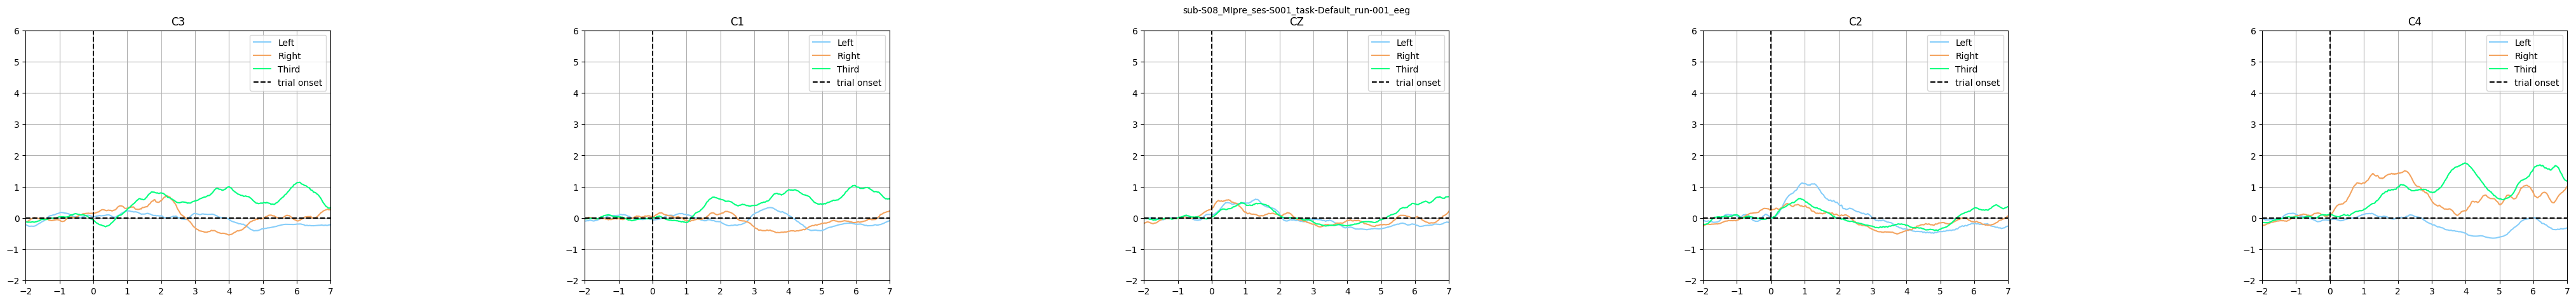

Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.4s finished


Applying baseline correction (mode: percent)


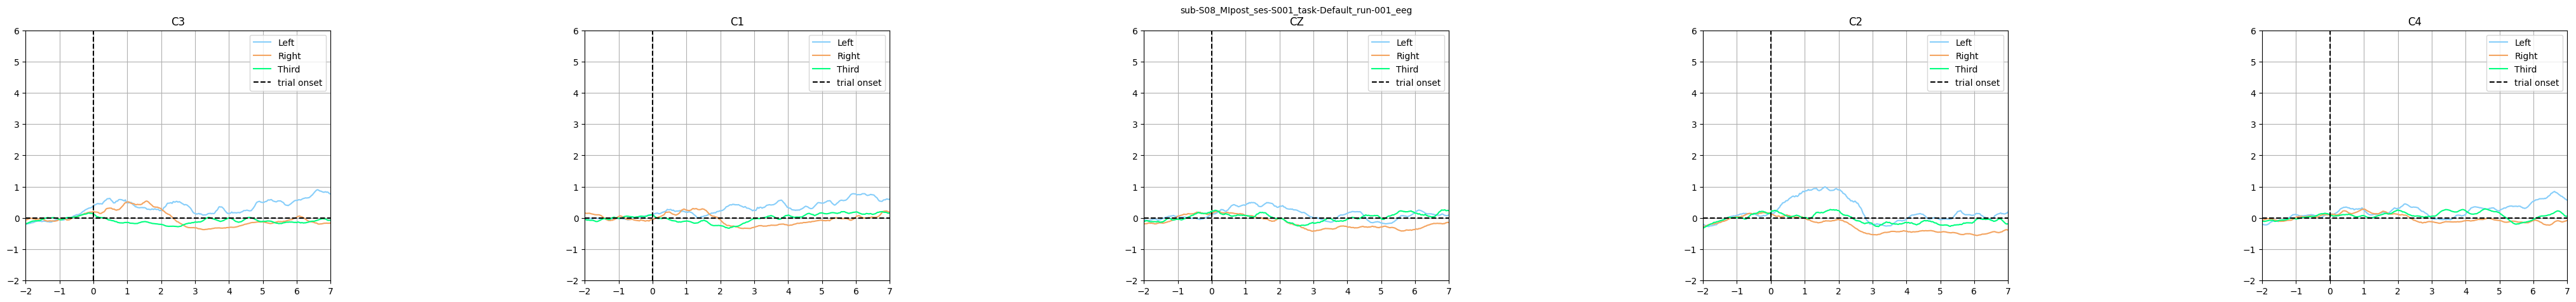

In [54]:
quick_ERDS(epoch_dict)

In [28]:
freqs = np.arange(1, 40)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-2, 0.)  # baseline interval (in s)
tmin = -2.
tmax = 7.
colors = {'Left':
          'lightskyblue',
          'Right':'sandybrown',
          'Third':'springgreen'
          }
dfs = []
frequencies = list(filters.keys())
path = get_dict_path(epoch_dict)
for cond in [MIPOST,MIPRE]:
    
    epochs = epoch_dict[cond]['epochs'].copy()
    epochs.load_data()
    picked_chs = ['C3','C1','CZ','C2','C4']
    epochs.pick(picked_chs)
    epochs.resample(500)
    
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                buffer_size=None, out_type='mask')  # for cluster test
    tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                        return_itc=False, average=False, decim=2)
    tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
    '''
    channels = tfr.ch_names
    trials = list(tfr.event_id.keys())
    freq_mask = (tfr.freqs >= 8) & (tfr.freqs <= 12)
    time_mask = (tfr.times >= 2)
    #fig,axs = plt.subplots(1,len(picked_chs))
    selection = tfr.data[:,:,freq_mask,time_mask]
    freq_avg = np.mean(selection,axis=2)
    tfr.data = freq_avg
    '''

    for freq in frequencies:
        for k,ch in enumerate(epochs.ch_names):
            current_tfr = tfr.copy().pick([ch])
            data = tfr.data
            freq_mask = (current_tfr.freqs >= filters[freq][0]) & (current_tfr.freqs <= filters[freq][1])
            time_mask_trial = (current_tfr.times >= 2)
            time_mask_cue = (current_tfr.times >= 0) & (current_tfr.times < 2)
            selection = current_tfr.data[:,:,freq_mask,:]
            selection_trial = selection[:,:,:,time_mask_trial]
            selection_cue = selection[:,:,:,time_mask_cue]
            freq_avg_trial = np.mean(selection_trial,axis=2)
            time_avg_trial = np.nanmean(freq_avg_trial,axis=-1)
            freq_avg_cue = np.mean(selection_cue,axis=2)
            time_avg_cue = np.nanmean(freq_avg_cue,axis=-1)
            df = pd.DataFrame(data={'trial_pwr':time_avg_trial.squeeze(),'cue_pwr':time_avg_cue.squeeze()})
            df['ch_name'] = ch
            df['band'] = freq
            df['condition'] = [x for x in ['MIpost','MIpre'] if x in cond][0]
            df['trial'] = map_events(current_tfr.events,current_tfr.event_id)
            df['epoch'] = np.arange(1,time_avg_trial.shape[0]+1)
            dfs.append(df)
    '''
    df = tfr.to_data_frame(time_format = None, long_format = True)
    # Map to frequency bands:
    
    freq_bounds = {'_': 0,
                'delta': 3,
                'theta': 7,
                'alpha': 12,
                'beta': 34,
                'gamma' : 140}
    df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                        labels=list(freq_bounds)[1:])
    # Filter to retain only relevant frequency bands:
    freq_bands_of_interest = ['theta','alpha','beta','gamma']
    df = df[df.band.isin(freq_bands_of_interest)]
    df['band'] = df['band'].cat.remove_unused_categories()
    df['channel'] = df['channel'].cat.reorder_categories(picked_chs,
                                                        ordered=True)
    #df.rename(columns={"condition": "trial"})                                                    
    
    '''
    
    '''
            epoch_avg = np.nanmean(freq_avg,axis=0)
            axs[k].plot(tfr.times,epoch_avg[0],color=colors[trial],label = trial)
        axs[k].grid(True)
        axs[k].set_ylim([-2, 6])
        axs[k].set_xlim([-2, 7])
        axs[k].axvline(x = baseline[1], color = 'black',linestyle="--", label = 'trial onset')
        axs[k].axhline(y = 0., color = 'black',linestyle="--")
        axs[k].legend()
        axs[k].set_title(ch)
    fig.tight_layout()
    fig.set_figwidth(len(picked_chs)*10)
    fig.suptitle(cond, fontsize=10)
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    plt.show()
    '''
    del epochs
result = pd.concat(dfs)
result['subject_ID'] = path.split('/')[2]
result['group'] = path.split('/')[1]
    

Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP1', 'C5', 'CP3']
1 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.8s finished


Applying baseline correction (mode: percent)
Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C4', 'CP5', 'CP6', 'C5', 'C2', 'C6']
    Rejecting  epoch based on EEG : ['CP5', 'CP6', 'C5']
2 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.5s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.4s finished


Applying baseline correction (mode: percent)


In [29]:
result = result.sort_values(by=['condition','epoch'])
result.head(80)

,trial_pwr,cue_pwr,ch_name,band,condition,trial,epoch,subject_ID,group
0,-0.618085,6.141136,C3,theta,MIpost,Right,1,S02,Group_Realistic_Arm
0,-0.703580,2.438827,C1,theta,MIpost,Right,1,S02,Group_Realistic_Arm
0,-0.653488,0.577023,CZ,theta,MIpost,Right,1,S02,Group_Realistic_Arm
0,-0.732957,1.095369,C2,theta,MIpost,Right,1,S02,Group_Realistic_Arm
0,-0.782080,2.158084,C4,theta,MIpost,Right,1,S02,Group_Realistic_Arm
...,...,...,...,...,...,...,...,...,...
3,-0.074283,0.107455,C3,gamma,MIpost,Left,4,S02,Group_Realistic_Arm
3,-0.118135,-0.272314,C1,gamma,MIpost,Left,4,S02,Group_Realistic_Arm
3,-0.168580,-0.097071,CZ,gamma,MIpost,Left,4,S02,Group_Realistic_Arm
3,-0.183053,-0.035866,C2,gamma,MIpost,Left,4,S02,Group_Realistic_Arm


In [30]:
save_erds_data(epoch_dict,filters)

Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C4', 'CP5', 'CP6', 'C5', 'C2', 'C6']
    Rejecting  epoch based on EEG : ['CP5', 'CP6', 'C5']
2 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.6s finished


Applying baseline correction (mode: percent)
Using data from preloaded Raw for 60 events and 20001 original time points ...
    Rejecting  epoch based on EEG : ['C3', 'CP5', 'CP1', 'C5', 'CP3']
1 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.6s finished


Applying baseline correction (mode: percent)


In [18]:
df = pd.read_csv(get_dict_path(epoch_dict)+'/ERDS/erds_data.csv')
df.head()

,trial_pwr,cue_pwr,ch_name,band,condition,trial,epoch,subject_ID,group
0,0.215770,1.399321,C3,theta,MIpost,Third,1,S01,Group_Realistic_Arm
1,0.161314,-0.289069,C3,theta,MIpost,Left,2,S01,Group_Realistic_Arm
2,-0.243697,-0.164601,C3,theta,MIpost,Left,3,S01,Group_Realistic_Arm
3,-0.081931,-0.183062,C3,theta,MIpost,Right,4,S01,Group_Realistic_Arm
4,-0.366261,-0.631333,C3,theta,MIpost,Right,5,S01,Group_Realistic_Arm


In [ ]:
epochs = epoch_dict[MIPOST]['epochs'].copy()
epochs.load_data()
picked_chs = ['C3','C1','CZ','C2','C4']
epochs.pick(picked_chs)
epochs.resample(500)
    
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
            buffer_size=None, out_type='mask')  # for cluster test
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                        return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

In [107]:
result = pd.concat(dfs)

In [ ]:
map_events(tfr.events,tfr.event_id)

In [ ]:
result.sort_values(by=['condition','band','trial'])

In [ ]:
epoch_dict[cond]['epochs'].ch_names

In [31]:
result = result.sort_values(by=['epoch','time','channel','band'])

In [ ]:
result[result['band'] == 'alpha'].head(100)

In [ ]:
events = tfr.events
events_id = tfr.event_id
trials = list(events_id.keys())
events = events[:,2]
res = pd.Series(events)
for trial in trials:
    res[res==events_id[trial]] = trial

print(res)

### Save erds data for all subjects

In [10]:
%%capture
subject_ID = np.arange(20,21)
last_id = 0

for idx in subject_ID:
    last_id = idx
    EEG_dict_RAW,EEG_dict_corrected,EEG_dict_corrected_CAR,EEG_filtered,EVENTS_dict = get_subject(idx,mode='eye_blink')
    conditions = list(EEG_dict_corrected.keys())
    epoch_dict = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)
    epoch_dict = reject_bad_chs(epoch_dict)
    save_erds_data(epoch_dict,filters)
    

In [39]:
print(last_id)

17


### Assemble the data from all subjects into one dataframe

In [5]:
subject_ID = np.arange(1,21)

dfs = []
for id in subject_ID:
    path = get_subject_path(id)
    dfs.append(pd.read_csv(path+'/ERDS/erds_data.csv'))
res = pd.concat(dfs)

In [6]:
res

,trial_pwr,cue_pwr,ch_name,band,condition,trial,epoch,subject_ID,group
0,-0.170905,0.637944,C5,theta,MIpost,Third,1,S01,Group_Realistic_Arm
1,0.182164,0.207087,C5,theta,MIpost,Left,2,S01,Group_Realistic_Arm
2,0.080565,0.126645,C5,theta,MIpost,Left,3,S01,Group_Realistic_Arm
3,0.321206,0.155249,C5,theta,MIpost,Right,4,S01,Group_Realistic_Arm
4,-0.025044,-0.080157,C5,theta,MIpost,Right,5,S01,Group_Realistic_Arm
...,...,...,...,...,...,...,...,...,...
3131,-0.015656,-0.004596,C6,gamma,MIpre,Right,51,S20,Group_Realistic_Arm_Tactile
3132,1.101376,2.436559,C6,gamma,MIpre,Right,52,S20,Group_Realistic_Arm_Tactile
3133,-0.207336,-0.047934,C6,gamma,MIpre,Right,53,S20,Group_Realistic_Arm_Tactile
3134,0.070828,0.683735,C6,gamma,MIpre,Third,54,S20,Group_Realistic_Arm_Tactile


### Data Visualization

In [7]:
from itertools import combinations
from statannotations.Annotator import Annotator

In [ ]:
t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal, Brunner-Munzel.

In [ ]:
%%capture
groups = res['group'].unique()
bands = res['band'].unique()
path = 'Data/stat_analysis_results/'
isExist = os.path.exists(path)

if not isExist:
    os.makedirs(path)
for group in groups:
    for band in bands:

        conditions = res['condition'].unique()

        channels = res['ch_name'].unique()
        fig,axs = plt.subplots(1,len(channels),figsize=(20,5),sharey=True)
        colors = {'Left':'lightskyblue',
                    'Right':'sandybrown',
                    'Third':'springgreen'
                    }

        lines, labels = [], []

        pairs = [[('MIpost','Left'),('MIpre','Left')],
                [('MIpost','Right'),('MIpre','Right')],
                [('MIpost','Third'),('MIpre','Third')]]

        '''
        pairs = [[('MIpost','Left'),('MIpost','Right')],
                [('MIpost','Left'),('MIpost','Third')],
                [('MIpost','Third'),('MIpost','Right')],
                [('MIpre','Left'),('MIpre','Right')],
                [('MIpre','Left'),('MIpre','Third')],
                [('MIpre','Third'),('MIpre','Right')]]
        '''
        for i,ch in enumerate(channels):
            df = res[(res['group']==group)&(res['band']==band)&(res['ch_name']==ch)]
            ax = sns.boxplot(data=df, x="condition", y="trial_pwr", hue="trial",ax=axs[i],palette=colors,showfliers = False)
            annotator = Annotator(ax, pairs, data=df, x="condition", y="trial_pwr", hue="trial",palette=colors,showfliers = False)
            annotator.configure(test="t-test_welch", text_format="star")
            annotator.apply_and_annotate()
            axs[i].set_title(f'{ch}')
            axs[i].legend(loc='center right')
            Line, Label = axs[i].get_legend_handles_labels()
            # print(Label)
            lines.extend(Line)
            labels.extend(Label)
            axs[i].get_legend().remove()
            axs[i].set(xlabel=None)
            axs[i].set(ylabel=None)
            
            
        '''
        for ax in fig.axes:
            Line, Label = ax.get_legend_handles_labels()
            # print(Label)
            lines.extend(Line)
            labels.extend(Label)
        '''
        fig.legend(lines[:3], labels[:3], loc='upper right')
        fig.suptitle(f'{group} - {band}')
        fig.supxlabel('Condition')
        fig.supylabel('Trial power average')
        #plt.legend(loc='center right')
        fig.savefig(path+f'{group}_{band}.png')

In [12]:
annotator.configure?

Signature: annotator.configure(**parameters)
Docstring:
* `alpha`: Acceptable type 1 error for statistical tests, default 0.05
* `color`
* `comparisons_correction`: Method for multiple comparisons correction.
    One of `statsmodels` `multipletests` methods (w/ default FWER), or
    a `ComparisonsCorrection` instance.
* `correction_format`: How to format the star notation on the plot when
    the multiple comparisons correction method removes the significance
    * `default`: a ' (ns)' suffix is added, such as in printed output,
    corresponds to "{star} ({suffix})"
    * `replace`: the original star value is replaced with 'ns'
    corresponds to "{suffix}"
    * a custom formatting string using "{star}" for the original
    pvalue and '{suffix}' for 'ns'
* `line_height`: in axes fraction coordinates
* `line_offset`
* `line_offset_to_group`
* `line_width`
* `loc`
* `pvalue_format`: list of lists, or tuples. Default values are:
    * For "star" text_format:
      `[[1e-4, "****"], [1e-

In [13]:
annotator.apply_and_annotate?

Signature: annotator.apply_and_annotate()
Docstring: Applies a configured statistical test and annotates the plot
File:      c:\users\haiou\python-env\.venv\env_tne\lib\site-packages\statannotations\annotator.py
Type:      method

### Statistical-analysis

In [15]:
def compute_anova(df):
    
    anova_df = []
    t_test_df = []
    types = ['trial_pwr','cue_pwr']
    '''
    #subjects = res['subject_ID'].unique()
    for subject in subjects:

        sub_df = res[res['subject_ID']==subject]
    '''
    groups = df['group'].unique()
    conditions = df['condition'].unique()
        
    bands = df['band'].unique()

    for group in groups:
        for cond in conditions:
            ch_names = df[df['condition']==cond]['ch_name'].unique()
            for ch in ch_names:
                for band in bands:
                    for data_type in types:

                        mod = ols(f'{data_type} ~ C(trial)',data=df[(df['condition']==cond)&(df['ch_name']==ch)&(df['band']==band)&(df['group']==group)]).fit()
                        aov_table = sm.stats.anova_lm(mod,typ=2)
                        #aov_table['subject_ID'] = subject
                        aov_table['group'] = group
                        aov_table['condition'] = cond
                        aov_table['ch_name'] = ch
                        aov_table['band'] = band
                        aov_table['type'] = data_type
                            
                        anova_df.append(aov_table)
                            
                        pair_t = mod.t_test_pairwise('C(trial)')
                            
                        pair_t = pair_t.result_frame
                        #pair_t['subject_ID'] = subject
                        pair_t['group'] = group
                        pair_t['condition'] = cond
                        pair_t['ch_name'] = ch
                        pair_t['band'] = band
                        pair_t['comparison'] = pair_t.index
                        pair_t['type'] = data_type

                        t_test_df.append(pair_t)
    return pd.concat(anova_df),pd.concat(t_test_df)

def compute_anova_two_way(df):
    anova_df = []
    t_test_df = []
    types = ['trial_pwr','cue_pwr']
    '''
    #subjects = res['subject_ID'].unique()
    for subject in subjects:

        sub_df = res[res['subject_ID']==subject]
    '''
    groups = df['group'].unique()
        
    bands = df['band'].unique()

    for group in groups:
        ch_names = df['ch_name'].unique()
        for ch in ch_names:
            for band in bands:
                for data_type in types:

                    mod = ols(f'{data_type} ~ trial + condition',data=df[(df['ch_name']==ch)&(df['band']==band)&(df['group']==group)]).fit()
                    aov_table = sm.stats.anova_lm(mod,typ=2)
                    #aov_table['subject_ID'] = subject
                    aov_table['group'] = group
                    aov_table['ch_name'] = ch
                    aov_table['band'] = band
                    aov_table['type'] = data_type
                            
                    anova_df.append(aov_table)
                            
                    pair_t = mod.t_test_pairwise('trial')
                            
                    pair_t = pair_t.result_frame
                    #pair_t['subject_ID'] = subject
                    pair_t['group'] = group
                    pair_t['ch_name'] = ch
                    pair_t['band'] = band
                    pair_t['comparison'] = pair_t.index
                    pair_t['type'] = data_type

                    t_test_df.append(pair_t)
    return pd.concat(anova_df),pd.concat(t_test_df)

In [ ]:
subjects = res['subject_ID'].unique()
anova_df = []
t_test_df = []
types = ['trial_pwr','cue_pwr']
for subject in subjects:

    sub_df = res[res['subject_ID']==subject]
    conditions = sub_df['condition'].unique()
    
    bands = sub_df['band'].unique()
    for cond in conditions:
        ch_names = sub_df[sub_df['condition']==cond]['ch_name'].unique()
        for ch in ch_names:
            for band in bands:
                for data_type in types:

                    mod = ols(f'{data_type} ~ trial',data=sub_df[(sub_df['condition']==cond)&(sub_df['ch_name']==ch)&(sub_df['band']==band)]).fit()
                    aov_table = sm.stats.anova_lm(mod,typ=2)
                    aov_table['subject_ID'] = subject
                    aov_table['condition'] = cond
                    aov_table['ch_name'] = ch
                    aov_table['band'] = band
                    aov_table['type'] = data_type
                    
                    anova_df.append(aov_table)
                    
                    pair_t = mod.t_test_pairwise('trial')
                    
                    pair_t = pair_t.result_frame
                    pair_t['subject_ID'] = subject
                    pair_t['condition'] = cond
                    pair_t['ch_name'] = ch
                    pair_t['band'] = band
                    pair_t['comparison'] = pair_t.index
                    pair_t['type'] = data_type

                    t_test_df.append(pair_t)


In [9]:
df_anova,df_t = compute_anova(res)

In [20]:
df_t[(df_t['band']=='alpha')&(df_t['ch_name']=='C5')].head(30)

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs,group,condition,ch_name,band,comparison,type
Right-Left,0.054229,0.074900,0.724016,0.469465,-0.093003,0.201461,0.718533,False,Group_Realistic_Arm,MIpost,C5,alpha,Right-Left,trial_pwr
Third-Left,0.095292,0.074900,1.272260,0.203995,-0.051940,0.242524,0.495632,False,Group_Realistic_Arm,MIpost,C5,alpha,Third-Left,trial_pwr
Third-Right,0.041064,0.074900,0.548244,0.583820,-0.106168,0.188296,0.718533,False,Group_Realistic_Arm,MIpost,C5,alpha,Third-Right,trial_pwr
Right-Left,-0.009675,0.088171,-0.109730,0.912677,-0.182995,0.163644,0.932943,False,Group_Realistic_Arm,MIpost,C5,alpha,Right-Left,cue_pwr
Third-Left,-0.047071,0.088171,-0.533854,0.593729,-0.220390,0.126249,0.932943,False,Group_Realistic_Arm,MIpost,C5,alpha,Third-Left,cue_pwr
Third-Right,-0.037396,0.088171,-0.424124,0.671696,-0.210715,0.135924,0.932943,False,Group_Realistic_Arm,MIpost,C5,alpha,Third-Right,cue_pwr
Right-Left,0.122166,0.072165,1.692856,0.091399,-0.019781,0.264112,0.174444,False,Group_Realistic_Arm,MIpre,C5,alpha,Right-Left,trial_pwr
Third-Left,0.169998,0.071049,2.392693,0.017267,0.030247,0.309748,0.050913,False,Group_Realistic_Arm,MIpre,C5,alpha,Third-Left,trial_pwr
Third-Right,0.047832,0.072015,0.664195,0.507015,-0.093819,0.189483,0.507015,False,Group_Realistic_Arm,MIpre,C5,alpha,Third-Right,trial_pwr
Right-Left,0.132454,0.102881,1.287454,0.198812,-0.069909,0.334817,0.485715,False,Group_Realistic_Arm,MIpre,C5,alpha,Right-Left,cue_pwr


In [85]:
df_anova

,sum_sq,df,F,PR(>F),group,ch_name,band,type
trial,0.935317,2.0,1.283693,0.277615,Group_Realistic_Arm,C5,theta,trial_pwr
condition,0.004227,1.0,0.011603,0.914249,Group_Realistic_Arm,C5,theta,trial_pwr
Residual,275.416027,756.0,NaN,NaN,Group_Realistic_Arm,C5,theta,trial_pwr
trial,1.996838,2.0,1.596554,0.203276,Group_Realistic_Arm,C5,theta,cue_pwr
condition,2.867016,1.0,4.584595,0.032580,Group_Realistic_Arm,C5,theta,cue_pwr
...,...,...,...,...,...,...,...,...
condition,220.472485,1.0,1.306963,0.253313,Group_Realistic_Arm_Tactile,C6,gamma,trial_pwr
Residual,125505.901351,744.0,NaN,NaN,Group_Realistic_Arm_Tactile,C6,gamma,trial_pwr
trial,0.623011,2.0,0.410149,0.663701,Group_Realistic_Arm_Tactile,C6,gamma,cue_pwr
condition,1.819944,1.0,2.396262,0.122051,Group_Realistic_Arm_Tactile,C6,gamma,cue_pwr


In [41]:
df = df_anova[(df_anova.index=='trial')&(df_anova['PR(>F)']<0.05)]
df.sort_values(by=['subject_ID'])

,sum_sq,df,F,PR(>F),subject_ID,condition,ch_name,band,type
trial,1.964236,2.0,4.163849,0.020612,S01,MIpost,C5,gamma,trial_pwr
trial,2.664637,2.0,3.635191,0.032783,S01,MIpost,C3,gamma,trial_pwr
trial,0.765277,2.0,3.408027,0.040113,S01,MIpost,C2,beta,cue_pwr
trial,1.540296,2.0,4.011092,0.023987,S01,MIpre,C6,gamma,cue_pwr
trial,0.498906,2.0,3.812633,0.028031,S02,MIpost,C3,alpha,trial_pwr
...,...,...,...,...,...,...,...,...,...
trial,1.792472,2.0,5.549441,0.006429,S20,MIpost,C3,beta,cue_pwr
trial,5.446210,2.0,3.953554,0.024983,S20,MIpost,C5,theta,trial_pwr
trial,5.278110,2.0,3.835495,0.027698,S20,MIpost,C4,gamma,cue_pwr
trial,2.534621,2.0,4.863014,0.011431,S20,MIpost,C1,gamma,cue_pwr


In [43]:
df = res[(res['band']=='alpha')&(res['group']=='Group_Realistic_Arm_Tactile')&(res['ch_name']=='C5')]
# Performing two-way ANOVA
model = ols(
    'trial_pwr ~ C(condition) + C(trial) +\
    C(condition):C(trial)', data=df).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(condition),0.006709,1.0,0.012899,0.909610
C(trial),1.637584,2.0,1.574200,0.207914
C(condition):C(trial),0.191961,2.0,0.184531,0.831535
Residual,359.931421,692.0,NaN,NaN


In [44]:
import statsmodels
print(statsmodels.stats.multicomp.pairwise_tukeyhsd(endog=df['trial_pwr'], groups=df['trial'], alpha=0.05))


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Left  Right  -0.0551 0.6875 -0.2119 0.1017  False
  Left  Third   0.0636 0.6058 -0.0929 0.2201  False
 Right  Third   0.1187 0.1784 -0.0383 0.2757  False
---------------------------------------------------


In [45]:
print(statsmodels.stats.multicomp.pairwise_tukeyhsd(endog=df['trial_pwr'], groups=df['condition'], alpha=0.05))

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
MIpost  MIpre   0.0062 0.9102 -0.1021 0.1146  False
---------------------------------------------------


### Visualisation with stat

In [46]:
(res.subject_ID.isin(df.subject_ID))&(res.condition.isin(df.condition))&(res.ch_name.isin(df.ch_name))&(res.band.isin(df.band))

0       True
1       True
2       True
3       True
4       True
        ... 
3131    True
3132    True
3133    True
3134    True
3135    True
Length: 53976, dtype: bool

In [42]:
res[(res.subject_ID.isin(df.subject_ID))&(res.condition.isin(df.condition))&(res.ch_name.isin(df.ch_name))&(res.band.isin(df.band))]

,trial_pwr,cue_pwr,ch_name,band,condition,trial,epoch,subject_ID,group
0,-0.170905,0.637944,C5,theta,MIpost,Third,1,S01,Group_Realistic_Arm
1,0.182164,0.207087,C5,theta,MIpost,Left,2,S01,Group_Realistic_Arm
2,0.080565,0.126645,C5,theta,MIpost,Left,3,S01,Group_Realistic_Arm
3,0.321206,0.155249,C5,theta,MIpost,Right,4,S01,Group_Realistic_Arm
4,-0.025044,-0.080157,C5,theta,MIpost,Right,5,S01,Group_Realistic_Arm
...,...,...,...,...,...,...,...,...,...
3131,-0.015656,-0.004596,C6,gamma,MIpre,Right,51,S20,Group_Realistic_Arm_Tactile
3132,1.101376,2.436559,C6,gamma,MIpre,Right,52,S20,Group_Realistic_Arm_Tactile
3133,-0.207336,-0.047934,C6,gamma,MIpre,Right,53,S20,Group_Realistic_Arm_Tactile
3134,0.070828,0.683735,C6,gamma,MIpre,Third,54,S20,Group_Realistic_Arm_Tactile


In [44]:
df_anova,df_t = compute_anova(res[(res.subject_ID.isin(df.subject_ID))&(res.condition.isin(df.condition))&(res.ch_name.isin(df.ch_name))&(res.band.isin(df.band))])

In [45]:
df_anova.head()

,sum_sq,df,F,PR(>F),subject_ID,condition,ch_name,band,type
trial,1.134072,2.0,1.338170,0.270583,S01,MIpost,C5,theta,trial_pwr
Residual,23.729443,56.0,NaN,NaN,S01,MIpost,C5,theta,trial_pwr
trial,1.733694,2.0,0.686233,0.507652,S01,MIpost,C5,theta,cue_pwr
Residual,70.738992,56.0,NaN,NaN,S01,MIpost,C5,theta,cue_pwr
trial,0.078616,2.0,0.187141,0.829844,S01,MIpost,C5,alpha,trial_pwr


In [ ]:
subject = 'S08'
band='alpha'
df = df_anova[(df_anova.index=='trial')&(df_anova['PR(>F)']<0.05)]
conditions = df['condition'].unique()

channels = res['ch_name'].unique()
fig,axs = plt.subplots(1,len(channels),figsize=(15,5),sharey=True)
for i,ch in enumerate(channels):
    df = res[(res['subject_ID']==subject)&(res['band']==band)&(res['ch_name']==ch)]
    sns.boxplot(data=df, x="condition", y="trial_pwr", hue="trial",ax=axs[i])
    axs[i].set_title(f'{ch}')

fig.suptitle(f'{subject} - {band}')
plt.legend()
plt.show()

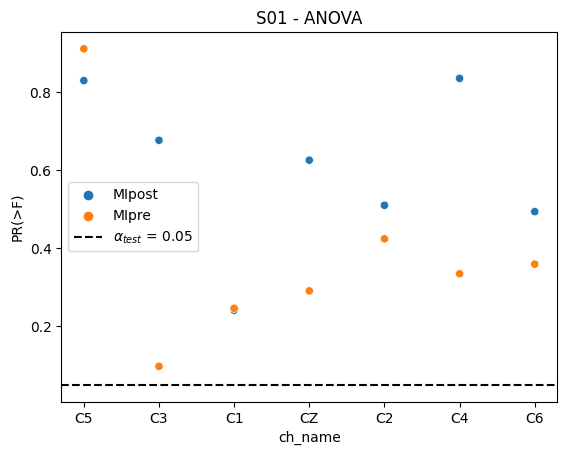

In [99]:
ax = sns.scatterplot(data=df_anova[(df_anova['subject_ID']=='S01')&(df_anova['band']=='alpha')], x="ch_name", y="PR(>F)", hue="condition")
ax.set_title('S01 - ANOVA')
plt.axhline(y=0.05,color='black',linestyle='--',label=r'$\alpha_{test}$ = 0.05')
plt.legend()
plt.show()

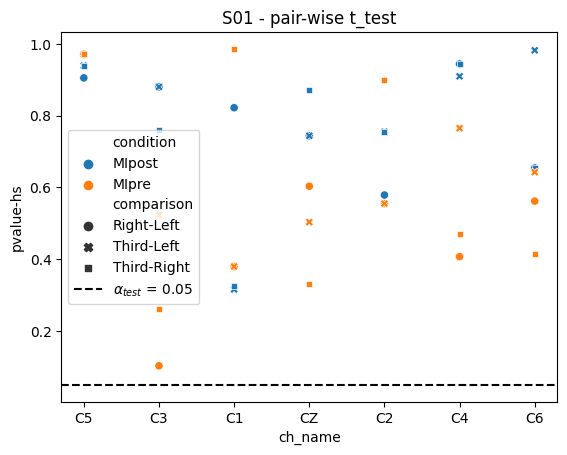

In [98]:
ax = sns.scatterplot(data=df_t[(df_t['subject_ID']=='S01')&(df_t['band']=='alpha')], x="ch_name", y="pvalue-hs", hue="condition",style='comparison')
ax.set_title('S01 - pair-wise t_test')
plt.axhline(y=0.05,color='black',linestyle='--',label=r'$\alpha_{test}$ = 0.05')
plt.legend()
plt.show()

### Manual model

In [ ]:
mod = ols(f'{data_type} ~ trial',data=sub_df[(sub_df['condition']==cond)&(sub_df['ch_name']==ch)&(sub_df['band']==band)]).fit()

In [9]:
subjects = res['subject_ID'].unique()
sub_df = res[res['subject_ID']==subjects[7]]
conditions = sub_df['condition'].unique()
    
bands = sub_df['band'].unique()
ch_names = sub_df[sub_df['condition']=='MIpost']['ch_name'].unique()
mod = ols('trial_pwr ~ trial',data=sub_df[(sub_df['condition']=='MIpost')&(sub_df['ch_name']=='C5')&(sub_df['band']=='alpha')]).fit()

In [10]:
aov_table = sm.stats.anova_lm(mod,typ=2)
print(aov_table)
aov_table.head()


            sum_sq    df        F    PR(>F)
trial     0.269707   2.0  1.12792  0.330823
Residual  6.814896  57.0      NaN       NaN


,sum_sq,df,F,PR(>F)
trial,0.269707,2.0,1.12792,0.330823
Residual,6.814896,57.0,NaN,NaN


In [54]:
pair_t = mod.t_test_pairwise('trial')
pair_t.result_frame
pair_t.result_frame.head()

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Right-Left,-0.016007,0.027219,-0.588069,0.556572,-0.069396,0.037383,0.619354,False
Third-Left,-0.040076,0.027219,-1.472350,0.141131,-0.093465,0.013314,0.366451,False
Third-Right,-0.024069,0.027584,-0.872567,0.383035,-0.078176,0.030038,0.619354,False


In [11]:
pair_t?

Type:        MultiCompResult
String form: <statsmodels.stats.contrast.MultiCompResult object at 0x000001995297C580>
File:        c:\users\haiou\python-env\.venv\env_tne\lib\site-packages\statsmodels\stats\contrast.py
Docstring:  
class to hold return of t_test_pairwise

currently just a minimal class to hold attributes.

## Custom f-score

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 20001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 9 DPSS windows
(60, 13, 19)
(60, 247)
(60,)


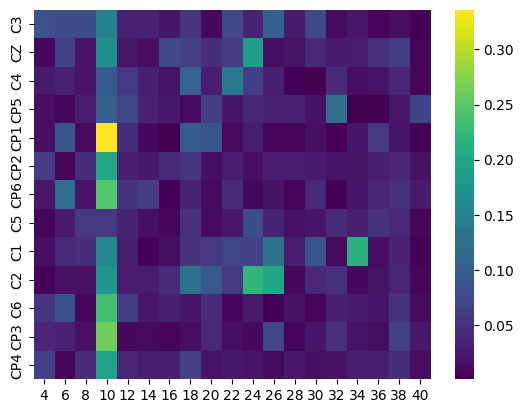

In [36]:
EEG_dict_corrected_CAR = get_epochs(EEG_dict_corrected_CAR,EVENTS_dict)
freqs = np.arange(4,41,2)
epochs = EEG_dict_corrected_CAR[MIPOST]['epochs'].copy()
epochs.load_data()
epochs.crop(2,7)
epochs.resample(500)
picks = [ch for ch in epochs.ch_names if ch not in epochs.info['bads']]
fft = mne.time_frequency.psd_array_multitaper(epochs.get_data(picks=picks), epochs.info['sfreq'], fmin=0.0, fmax=40, bandwidth=2)
bandpower = fft[0]
current_freqs = fft[1]
IDs = np.where(np.in1d(current_freqs,freqs))
print(np.squeeze(bandpower[:,:,IDs]).shape)
bandpower = np.squeeze(bandpower[:,:,IDs])

x = np.squeeze(bandpower)
X = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
print(X.shape)
y = epochs.events[:,2].copy()
print(y.shape)

inputs = X
labels = y    
# Compute the number of features and number of samples
n_samples = len(labels)
n_features = inputs.shape[1]

# Compute the number of classes
classes = np.unique(labels)
n_classes = len(classes)

# Compute feature mean
feature_mean = np.nanmean(inputs, axis=0)

# Compute mean and std for features class-wise
class_means = np.zeros((n_classes, n_features))
class_var = np.zeros((n_classes, n_features))

for i,c in enumerate(classes):
    class_means[i] = np.nanmean(inputs[labels == c], axis=0)
    class_var[i] = np.nanvar(inputs[labels == c], axis=0)
    
f_scores = np.zeros((n_features,))
new_mean = class_means-feature_mean

for n in range(n_features):
    f_scores[n] = np.sum(np.square(new_mean[:,n]))/np.sum(class_var[:,n])
f_scores = f_scores.reshape(x.shape[1],x.shape[2])

sns.heatmap(f_scores,cmap = "viridis",xticklabels=freqs, yticklabels=picks)
plt.show()

##### Compute bandpower

In [89]:
spectrum = epochs.compute_psd(fmin=0,fmax=40)
bandpower = spectrum.get_data()
current_freqs = spectrum.freqs


    Using multitaper spectrum estimation with 7 DPSS windows


In [57]:
tfr = mne.time_frequency.tfr_array_multitaper(epochs.get_data(picks=picks), epochs.info['sfreq'], freqs, n_cycles=7.0, zero_mean=True, time_bandwidth=4.0, use_fft=True, decim=1, output='power', n_jobs=None)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    8.8s finished


In [58]:
bandpower = np.mean(tfr,axis=-1)

In [71]:

tfr = mne.time_frequency.tfr_multitaper(epochs, freqs, n_cycles=freqs, time_bandwidth=4.0, use_fft=True, return_itc=False, decim=1, n_jobs=None, picks=None, average=False)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.8s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   10.1s finished


In [76]:
tfr.crop(2,7)
bandpower = np.mean(tfr.data,axis=-1)

C:\Users\haiou\AppData\Local\Temp\ipykernel_18408\3667231500.py:1: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmax (6.998 sec)
  tfr.crop(2,7)


##### Compute Matrix

In [20]:
x = np.squeeze(bandpower)
X = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
print(X.shape)
y = epochs.events[:,2].copy()
print(y.shape)

(58, 2211)
(58,)


In [21]:
inputs = X
labels = y    
# Compute the number of features and number of samples
n_samples = len(labels)
n_features = inputs.shape[1]

# Compute the number of classes
classes = np.unique(labels)
n_classes = len(classes)

# Compute feature mean
feature_mean = np.nanmean(inputs, axis=0)

# Compute mean and std for features class-wise
class_means = np.zeros((n_classes, n_features))
class_var = np.zeros((n_classes, n_features))

for i,c in enumerate(classes):
    class_means[i] = np.nanmean(inputs[labels == c], axis=0)
    class_var[i] = np.nanvar(inputs[labels == c], axis=0)
    
f_scores = np.zeros((n_features,))
new_mean = class_means-feature_mean

for n in range(n_features):
    f_scores[n] = np.sum(np.square(new_mean[:,n]))/np.sum(class_var[:,n])
f_scores = f_scores.reshape(x.shape[1],x.shape[2])
print(f_scores.shape)

(11, 201)


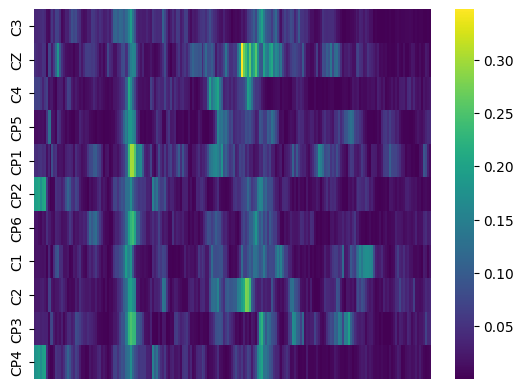

In [23]:
sns.heatmap(f_scores,cmap = "viridis",xticklabels=freqs, yticklabels=picks)
plt.show()

In [44]:
%%capture
subject_IDS = np.arange(1,21)
for idx in subject_IDS:
    EEG_dict_RAW,EEG_dict_corrected,EEG_dict_corrected_CAR,EEG_filtered,EVENTS_dict = get_subject(idx,mode='eye_blink')
    conditions = list(EEG_dict_corrected.keys())
    MIPOST = [x for x in conditions if 'MIpost' in x][0]
    MIPRE = [x for x in conditions if 'MIpre' in x][0]
    fisher_analysis(EEG_dict_corrected_CAR,EVENTS_dict)

AttributeError: 'list' object has no attribute 'split'